# Loading

> Load data from spectral libraries.

In [ ]:
#| default_exp loading

In [ ]:
#| export
from abc import ABC, abstractmethod
from dataclasses import dataclass
import fastcore.all as fc
from fastcore.basics import patch
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import List
from uhina.preprocessing import SNV

In [19]:
#| exports
def plot_spectra(data, 
                 var: str = 'X',
                 n_spectra=None,  # Number of random spectra to plot (None for all)
                 snv: bool = False, # Apply SNV normalization
                 xlabel='Wavenumber ($cm^{-1}$)', ylabel='Absorbance',
                 figsize=(12, 4), locator=250, lw=1,
                 color='steelblue', alpha=0.1,  # Single color with opacity
                 tight_layout=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    
    X_data = getattr(data, var)
    if n_spectra is not None and n_spectra < data.X.shape[0]:
        # Select n random spectra
        indices = np.random.choice(X_data.shape[0], n_spectra, replace=False)
        X_subset = X_data[indices]
    else:
        X_subset = X_data
    
    
    X_subset = SNV().fit_transform(X_subset) if snv else X_subset
    
    for i in range(X_subset.shape[0]):
        ax.plot(data.X_names, X_subset[i], lw=lw, color=color, alpha=alpha)
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(locator))
    ax.grid(True)
    ax.invert_xaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if tight_layout:
        plt.tight_layout()
    
    return fig, ax

In [ ]:
#| exports
@dataclass
class SpectralData:
    X: np.ndarray
    X_names: np.ndarray
    y: np.ndarray
    y_names: np.ndarray
    sample_indices: np.ndarray
    dataset_names: np.ndarray
    dataset_labels: np.ndarray

In [ ]:
#| exports
fname_ossl = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'

In [ ]:
#| exports
class DataLoader(ABC):
    "Abstract class for data loading."
    @abstractmethod
    def load_data(self, 
                  analytes: str|list, # Analyte(s) of interest
                  ) -> tuple: # Return a tuple of the form (X, y, X_names, smp_idx, ds_name, ds_label)
        """Load data and return (X, y, X_names, smp_idx, ds_name, ds_label)."""
        pass

## OSSL loader

Describe OSSL ...

In [ ]:
#| exports
class OSSLLoader(DataLoader):
    "Load OSSL data and filter it by spectra type and analytes of interest."
    DTYPE_DICT = {
        'id.layer_local_c': 'object',
        'id.location_olc_txt': 'object',
        'id.dataset.site_ascii_txt': 'object',
        'id.scan_local_c': 'object',
        'layer.texture_usda_txt': 'object',
        'pedon.taxa_usda_txt': 'object',
        'horizon.designation_usda_txt': 'object',
        'location.country_iso.3166_txt': 'object',
        'surveyor.address_utf8_txt': 'object',
        'efferv_usda.a479_class': 'object',
        'scan.mir.date.begin_iso.8601_yyyy.mm.dd': 'object',
        'scan.mir.date.end_iso.8601_yyyy.mm.dd': 'object',
        'scan.mir.model.name_utf8_txt': 'object',
        'scan.mir.model.code_any_txt': 'object',
        'scan.mir.method.optics_any_txt': 'object',
        'scan.mir.method.preparation_any_txt': 'object',
        'scan.mir.license.title_ascii_txt': 'object',
        'scan.mir.license.address_idn_url': 'object',
        'scan.mir.doi_idf_url': 'object',
        'scan.mir.contact.name_utf8_txt': 'object',
        'scan.mir.contact.email_ietf_txt': 'object',
        'scan.visnir.date.begin_iso.8601_yyyy.mm.dd': 'object',
        'scan.visnir.date.end_iso.8601_yyyy.mm.dd': 'object',
        'scan.visnir.model.name_utf8_txt': 'object',
        'scan.visnir.model.code_any_txt': 'object',
        'scan.visnir.method.optics_any_txt': 'object',
        'scan.visnir.method.preparation_any_txt': 'object',
        'scan.visnir.license.title_ascii_txt': 'object',
        'scan.visnir.license.address_idn_url': 'object',
        'scan.visnir.doi_idf_url': 'object',
        'scan.visnir.contact.name_utf8_txt': 'object',
        'scan.visnir.contact.email_ietf_txt': 'object'
    }
    def __init__(self, 
                 src: Path = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz', # Data source file name
                 spectra_type: str='visnir', # Spectra type
                 cfgs: dict=None): # Spectra type configuration
        self.src = src
        self.spectra_type = spectra_type
        self.df = None
        self.ds_name_encoder = LabelEncoder()
        self.cfgs = cfgs or {
            'visnir': {'ref_col': 'scan_visnir.1500_ref', 'range': [400, 2500]},
            'mir': {'ref_col': 'scan_mir.1500_abs', 'range': [650, 4000]}
        }

    def _get_spectra(self, 
                    spectra_type: str # Spectra type
                    ):
        cols_ref = [name for name in self.df.columns if f'scan_{spectra_type}.' in name]
        X = self.df[cols_ref].values
        X_names = self._get_wavelengths(spectra_type)
        lower_limit, upper_limit = self.cfgs[spectra_type]['range']
        idxs = np.where((X_names >= lower_limit) & (X_names <= upper_limit))[0]
        return X[:, idxs], X_names[idxs]

    def _encode_dataset_names(self):
        return self.ds_name_encoder.fit_transform(self.df['dataset.code_ascii_txt'])

    def _get_wavelengths(self, 
                            spectra_type: str # Spectra type
                            ):
        pattern = r"scan_{}\.(\d+)_".format(spectra_type)
        return np.array([int(re.search(pattern, name).group(1)) for name in self.df.columns
                            if re.search(pattern, name)])
        
    def load_data(self, 
                  analytes: str|list, # Analyte(s) of interest
                  ) -> tuple: # Return a tuple of the form (X, y, X_names, smp_idx, ds_name, ds_label)
        "Load OSSL data and filter it by spectra type and analytes of interest."
        print(f'Loading data from {self.src} ...')
        self.df = pd.read_csv(self.src, dtype=self.DTYPE_DICT,
                              compression='infer', low_memory=True)

        analytes = [analytes] if isinstance(analytes, str) else analytes
        y_names = np.array(analytes)
        subset = analytes + [self.cfgs[self.spectra_type]['ref_col']]
        self.df = self.df.dropna(subset=subset, how='any')

        X, X_names = self._get_spectra(self.spectra_type)
        y = self.df[analytes].values
        smp_indices = self.df['id.layer_uuid_txt'].values
        ds_name = self._encode_dataset_names()
        
        return SpectralData(
            X=X,
            X_names=X_names,
            y=y,
            y_names=y_names,
            sample_indices=smp_indices,
            dataset_names=ds_name,
            dataset_labels=self.ds_name_encoder.classes_
        )

        # return X, y, X_names, smp_idx, ds_name, self.ds_name_encoder.classes_, np.array(analytes)


Usage example:

In [ ]:
#| eval: false
src = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'
loader = OSSLLoader(src=src, spectra_type='mir')

analytes = 'k.ext_usda.a725_cmolc.kg'
data = loader.load_data(analytes)

print(f'X shape: {data.X.shape}')
print(f'y shape: {data.y.shape}')
print(f'wavenumbers: {data.X_names}')
print(f'Analytes: {data.y_names}')
print(f'smp_idx: {data.sample_indices}')
print(f'ds_name: {data.dataset_names}')
print(f'ds_label: {data.dataset_labels}')

Loading data from /Users/franckalbinet/.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz ...
X shape: (57674, 1676)
y shape: (57674, 1)
wavenumbers: [ 650  652  654 ... 3996 3998 4000]
Analytes: ['k.ext_usda.a725_cmolc.kg']
smp_idx: ['3998362dd2659e2252cd7f38b43c9b1f' '2bab4dbbac073b8648475ad50d40eb95'
 '29213d2193232be8867d85dec463ec00' ... 'b790da349d49885c5727a2b5fd67b13d'
 'a057a7ead9eebce24d4039de7fd5e01b' '80bf4a0dc30f60552a38193d5c09b9cd']
ds_name: [0 0 0 ... 3 3 3]
ds_label: ['GARRETT.SSL' 'ICRAF.ISRIC' 'KSSL.SSL' 'LUCAS.WOODWELL.SSL']


In [ ]:
#| eval: false
#| hide
# For further testing, we save the first 10 samples of the dataset
n_samples = 10
fc.save_pickle('./files/spectrum-and-all.pkl', (
    data.X[:n_samples,:], 
    data.y[:n_samples], 
    data.X_names, 
    data.sample_indices[:n_samples], 
    data.dataset_names[:n_samples], 
    data.dataset_labels[:n_samples]
))

## Fukushima (Jumpei) data 

Describe Jumpei's data

In [ ]:
#| exports
class FukushimaJumpeiLoader(DataLoader):
    "Load Fukushima (Jumpei) data."
    fname = 'Fukushimaall_Average.csv'
    analytes = ['soil_total_Cs134',
                'soil_total_Cs137',
                'soil_ex_Cs137',
                'exCs137_totalCs137',
                'soil_water_soluble_K2O',
                'soil_ex_K2O',
                'TF_plant_totalCs137',
                'TF_plant_exCs137',
                'soil_pH',
                'soil_C',
                'soil_N',
                'soil_CN_ratio',
                'soil_CEC',
                'soil_MgO',
                'soil_CaO',
                'soil_P_absorption_coefficient',
                'avaiable_Pi',
                'course_sand',
                'fine_sand',
                'silt',
                'clay']
    
    def __init__(self, 
                 src: Path|str, # Source directory
                 ): 
        self.src = src if isinstance(src, Path) else Path(src)
        self.ds_name_encoder = LabelEncoder()
        
    def load_mir(self, df):
        wn_cols = [col for col in df.columns if col.isdigit()]
        return df[wn_cols].values, np.array([int(col) for col in wn_cols])
    
    def load_wetchem(self):
        fname = self.src / self.fname_wetchem
        return pd.read_csv(fname)
    
    def separate_spectra_and_others(self, df_merged: pd.DataFrame) -> tuple:
        "Separate the merged dataframe into spectral data and metadata."
        spectral_cols = [col for col in df_merged.columns if col.isdigit()]
        metadata_cols = [col for col in df_merged.columns if not col.isdigit()]
        df_spectra = df_merged[spectral_cols]
        df_others = df_merged[metadata_cols]
        return df_spectra, df_others
        
    def make_idx(self, df: pd.DataFrame) -> pd.DataFrame:
        "Make a unique index for the samples."
        return (df.iloc[:, :3].astype(str).apply('-'.join, axis=1))
    
    def _encode_dataset_names(self, df: pd.DataFrame):
        return self.ds_name_encoder.fit_transform(df)

    def load_data(self,
                  analytes: str|list=None, # Analytes of interest
                  ) -> tuple:
        "Load Ringtrial data and return SpectralData."
        df = pd.read_csv(self.src / self.fname, low_memory=False)
        X, X_names = self.load_mir(df)
    
        if analytes is None: analytes = self.analytes
    
        # y = df[analytes].values
        y = df[analytes].apply(pd.to_numeric, errors='coerce').values
        y_names = np.array(analytes)
        smp_indices = self.make_idx(df).values
        ds_name = self._encode_dataset_names(pd.Series(['fukushima-jumpei'] * len(df), index=df.index))
        
        return SpectralData(
            X=X,
            X_names=X_names,
            y=y,
            y_names=y_names,
            sample_indices=smp_indices,
            dataset_names=ds_name,
            dataset_labels=self.ds_name_encoder.classes_
        )

X shape: (635, 1675)
y shape: (635, 21)
wavenumbers: [ 650  652  654 ... 3996 3998 4000]
Analytes: ['soil_total_Cs134' 'soil_total_Cs137' 'soil_ex_Cs137'
 'exCs137_totalCs137' 'soil_water_soluble_K2O' 'soil_ex_K2O'
 'TF_plant_totalCs137' 'TF_plant_exCs137' 'soil_pH' 'soil_C' 'soil_N'
 'soil_CN_ratio' 'soil_CEC' 'soil_MgO' 'soil_CaO'
 'soil_P_absorption_coefficient' 'avaiable_Pi' 'course_sand' 'fine_sand'
 'silt' 'clay']
smp_idx: ['20-2013-paddy_rice' '28-2014-paddy_rice' '33-2014-paddy_rice'
 '35-2014-paddy_rice' '36-2014-paddy_rice' '38-2014-paddy_rice'
 '40-2014-paddy_rice' '41-2014-paddy_rice' '44-2014-paddy_rice'
 '49-2014-paddy_rice' '51-2015-paddy_rice' '53-2015-paddy_rice'
 '58-2015-paddy_rice' '64-2015-paddy_rice' '66-2015-paddy_rice'
 '68-2015-paddy_rice' '69-2015-paddy_rice' '72-2015-paddy_rice'
 '73-2015-paddy_rice' '74-2015-paddy_rice' '75-2015-paddy_rice'
 '78-2015-paddy_rice' '80-2016-paddy_rice' '81-2016-paddy_rice'
 '85-2016-paddy_rice' '93-2016-paddy_rice' '94-2016-pad

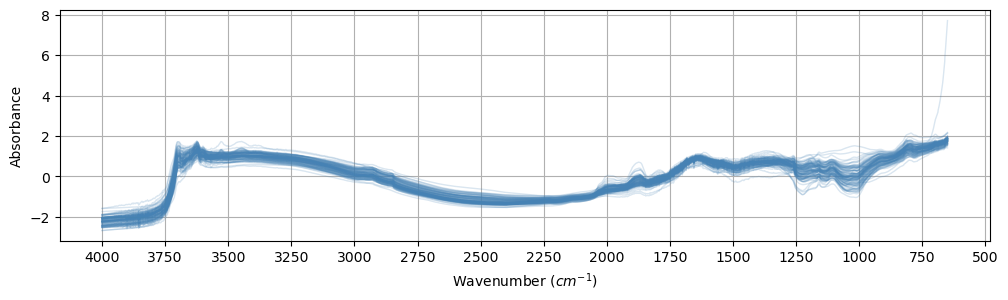

In [ ]:
#| eval: false
src = Path.home() / 'pro/data/fk-jumpei'
loader = FukushimaJumpeiLoader(src)
data = loader.load_data()

print(f'X shape: {data.X.shape}')
print(f'y shape: {data.y.shape}')
print(f'wavenumbers: {data.X_names}')
print(f'Analytes: {data.y_names}')
print(f'smp_idx: {data.sample_indices}')
print(f'ds_name: {data.dataset_names}')
print(f'ds_label: {data.dataset_labels}')

plot_spectra(data, n_spectra=100, snv=True, alpha=0.2, figsize=(12, 3));

## Ringtrial data

Describe Ringtrial ...

In [ ]:
#| exports
src_dir_rt = Path.home() / 'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001'

In [ ]:
#| exports
class RingtrialLoader(DataLoader):
    "Load Ringtrial data."
    fname_mir = 'RT_STD_allMIRspectra_raw.csv'
    fname_wetchem = 'RT_wetchem_soildata.csv'
    def __init__(self, 
                 src: Path|str = src_dir_rt, # Source directory
                #  target: str = 'soil_ex_K2O', # Target analyte
                 ): # Spectra type configuration
        self.src = src if isinstance(src, Path) else Path(src)
        self.ds_name_encoder = LabelEncoder()
        
    def load_mir(self):
        fname = self.src / self.fname_mir
        return pd.read_csv(fname)
    
    def load_wetchem(self):
        fname = self.src / self.fname_wetchem
        return pd.read_csv(fname)
    
    def separate_spectra_and_others(self, df_merged: pd.DataFrame) -> tuple:
        "Separate the merged dataframe into spectral data and metadata."
        spectral_cols = [col for col in df_merged.columns if col.isdigit()]
        metadata_cols = [col for col in df_merged.columns if not col.isdigit()]
        df_spectra = df_merged[spectral_cols]
        df_others = df_merged[metadata_cols]
        return df_spectra, df_others
        
    def make_idx(self, df: pd.DataFrame) -> pd.DataFrame:
        "Make a unique index for the samples."
        return (df['organization'] + '-' + df['sample_id']).str.lower().str.replace('_', '-')
    
    def _encode_dataset_names(self, df: pd.DataFrame):
        return self.ds_name_encoder.fit_transform(df)

    def load_data(self,
                  analytes: str|list='potassium_cmolkg', # Analytes of interest
                  ) -> tuple:
        "Load Ringtrial data and return (X, y, X_names, smp_idx, ds_name, ds_label)."
        df_merged = pd.merge(self.load_mir(), 
                            self.load_wetchem().rename(columns={'\tsample_id': 'sample_id'}),
                            on='sample_id', how='inner')
        
        df_spectra, df_others = self.separate_spectra_and_others(df_merged)
        
        X = df_spectra.values
        analytes = [analytes] if isinstance(analytes, str) else analytes
        y = df_others[analytes].values
        y_names = np.array(analytes)
        X_names = df_spectra.columns.astype(int).values
        smp_indices = self.make_idx(df_others).values
        ds_name = self._encode_dataset_names(df_others['organization'])
        
        return SpectralData(
            X=X,
            X_names=X_names,
            y=y,
            y_names=y_names,
            sample_indices=smp_indices,
            dataset_names=ds_name,
            dataset_labels=self.ds_name_encoder.classes_
        )

X shape: (1400, 1676)
y shape: (1400, 1)
wavenumbers: [ 650  652  654 ... 3996 3998 4000]
Analytes: ['potassium_cmolkg']
smp_idx: ['agrocares-rt-01' 'agrocares-rt-02' 'agrocares-rt-03' ...
 'woodwell-vertex-rt-68' 'woodwell-vertex-rt-69' 'woodwell-vertex-rt-70']
ds_name: [ 0  0  0 ... 19 19 19]
ds_label: ['Agrocares' 'Argonne' 'CSU_IL' 'ETH_alpha_1' 'ETH_alpha_2' 'ETH_vertex'
 'IAEA_aug2022' 'KSSL' 'LandCare' 'Lesotho' 'MSU' 'OSU' 'Rothamsted'
 'Scion' 'UGhent' 'UIUC' 'USP' 'UWisc_fine' 'Woodwell_alpha'
 'Woodwell_vertex']


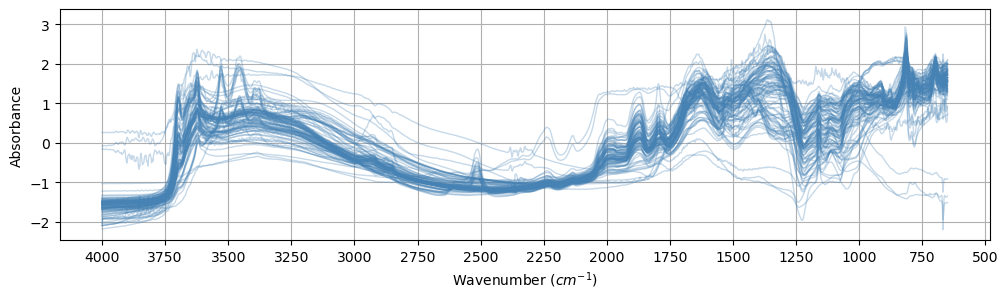

In [ ]:
#| eval: false
src = Path.home() / 'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001'

loader = RingtrialLoader(src)
data = RingtrialLoader().load_data()

print(f'X shape: {data.X.shape}')
print(f'y shape: {data.y.shape}')
print(f'wavenumbers: {data.X_names}')
print(f'Analytes: {data.y_names}')
print(f'smp_idx: {data.sample_indices}')
print(f'ds_name: {data.dataset_names}')
print(f'ds_label: {data.dataset_labels}')

plot_spectra(data, n_spectra=100, snv=True, alpha=0.3, figsize=(12, 3));

## Loader factory

This is a factory class to get the appropriate loader for a given dataset.

In [ ]:
#| exports
class LoaderFactory:
    @staticmethod
    def get_loader(src: Path, dataset: str, **kwargs) -> DataLoader:
        if dataset == 'ossl':
            return OSSLLoader(src, **kwargs)
        elif dataset == 'ringtrial':
            return RingtrialLoader(src)
        elif dataset == 'fk-jumpei':
            return FukushimaJumpeiLoader(src)
        else:
            raise ValueError(f"Dataset {dataset} not supported yet ...")

In [ ]:
#| eval: false
src = Path.home() / 'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001'
loader = LoaderFactory.get_loader(src, 'ringtrial')
data = loader.load_data(analytes='potassium_cmolkg')
print(f'X shape: {data.X.shape}')

X shape: (1400, 1676)


In [ ]:
#| eval: false
src = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'
loader = LoaderFactory.get_loader(src, 'ossl', spectra_type='mir')
data = loader.load_data(analytes='k.ext_usda.a725_cmolc.kg')
print(f'X shape: {data.X.shape}')

Loading data from /Users/franckalbinet/.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz ...


X shape: (57674, 1676)


In [ ]:
#| eval: false
src = Path.home() / 'pro/data/fk-jumpei'
loader = LoaderFactory.get_loader(src, 'fk-jumpei')
data = loader.load_data()
print(f'X shape: {data.X.shape}')

X shape: (635, 1675)
